In [1]:


import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [3]:
%cd '/content/drive/MyDrive/BTP/Fashion1'

/content/drive/MyDrive/BTP/Fashion1


In [11]:
def load_and_preprocess_data(debug=False):
    
    from tensorflow.keras.datasets.fashion_mnist import load_data

# Step-1: load the raw dataset
    (X_train, y_train), (X_test, y_test) = load_data()

    indexes = np.arange(X_train.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_train = X_train[indexes]
    y_train = y_train[indexes]
    X_train1=X_train.copy()
    y_train1=y_train.copy()
      #Train - 75%
      #Valid - 25% 
    val_count = 45000
    X_train=X_train1[:val_count]
    y_train=y_train1[:val_count]
    X_val = X_train1[val_count:]
    y_val = y_train1[val_count:]
    

    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()
    
# Step-3: scale the images
    # scale the images to between 0-1
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

# Step-4: reshape the images into 3D tensors so our CNN can consume it
    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

   

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [12]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), \
  (test_images, test_labels) = load_and_preprocess_data()

In [15]:
len(X_train)

45000

In [16]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    import seaborn as sns
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

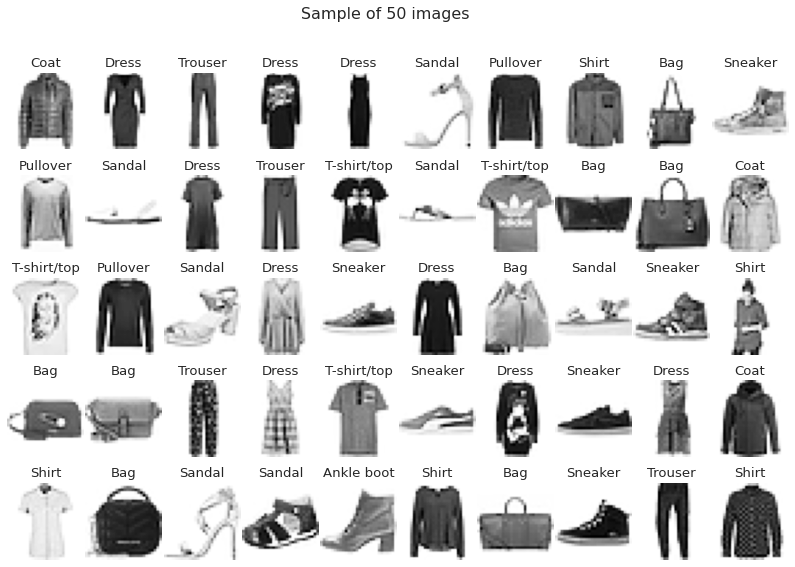

In [17]:
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, 
               plot_title='Sample of %d images' % sample_size)

In [18]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# these are my helper functions for Keras
import kr_helper_funcs as kru

IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

def build_model():
    """
    builds the base Keras model, without any regularization
    """
    K.clear_session()
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        
        Dense(512, activation='relu'),
        
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
trained_model=model.fit(X_train, y_train, epochs=20,
        batch_size=64, validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
704/704 [==============================] - 34s 34ms/step - loss: 0.4244 - accuracy: 0.8492 - val_loss: 0.3902 - val_accuracy: 0.8581
Epoch 2/20
704/704 [==============================] - 24s 34ms/step - loss: 0.2558 - accuracy: 0.9067 - val_loss: 0.2827 - val_accuracy: 0.8967
Epoch 3/20
704/704 [==============================] - 24s 34ms/step - loss: 0.1894 - accuracy: 0.9294 - val_loss: 0.2665 - val_accuracy: 0.9067
Epoch 4/20
704/704 [==============================] - 24s 33ms/step - loss: 0.1403 - accuracy: 0.9488 - val_loss: 0.2617 - val_accuracy: 0.9148
Epoch 5/20
704/704 [==============================] - 22s 32ms/step - loss: 0.1089 - accuracy: 0.9599 - val_loss: 0.3260 - val_accuracy: 0.8955
Epoch 6/20
704/704 [==============================] - 22s 31ms/step - loss: 0.0894 - accuracy: 0.9668 - val_loss: 0.3299 - val_accuracy: 0.9072
Epoch 7/20
704/704 [==============================] - 22s 31ms/step - loss: 0.0752 - accuracy: 0.9721 - val_loss: 0.2978 - val_accuracy:

In [22]:
model.save('/content/drive/MyDrive/BTP/Fashion1/f1.h5')

In [23]:
loss, acc = model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.4619 - accuracy: 0.9061


In [24]:
y=model.predict(X_test)
np.argmax(y[-2])

1

In [25]:
y_test

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [32]:
import cv2
test_image_path='/content/ankle-1.png'
image = cv2.imread(test_image_path)
image.resize(28,28)
image=np.reshape(image,(1, 28, 28, 1))
image=image.astype('float32') / 255.0
y12=model.predict(image)
print(y12)
np.argmax(y12)

[[4.9303094e-07 3.2477296e-06 7.8218598e-10 1.0934402e-05 4.6778879e-09
  8.9861976e-04 2.2725744e-07 9.9900180e-01 6.6422377e-05 1.8277900e-05]]


7

In [31]:
# load the image
#Correct
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
filename='/content/ankle-1.png'
img = load_img(filename, grayscale=True, target_size=(28, 28))

# convert to array
img = img_to_array(img)
# reshape into a single sample with 1 channel
img = img.reshape(1, 28, 28, 1)
# prepare pixel data
img = img.astype('float32')
img = img / 255.0
y11=model.predict(img)
print(y11)
np.argmax(y11)

[[1.5916235e-05 9.6878266e-06 1.5008806e-05 5.4397162e-07 9.3924557e-04
  2.2974352e-03 5.8586575e-06 1.2706628e-01 3.4210188e-06 8.6964667e-01]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


9

In [33]:
def show_history(model):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

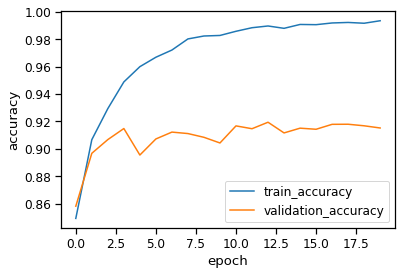

In [34]:
show_history(trained_model)

In [35]:
def show_history1(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

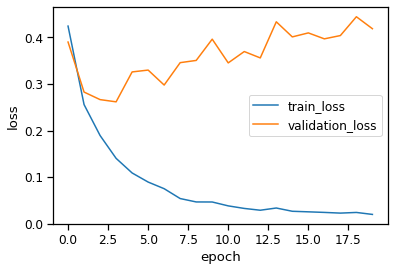

In [36]:
show_history1(trained_model)